## Preliminaries

In [2]:
%cd ~/code/textrec/

/Users/kcarnold/code/textrec


In [3]:
%matplotlib inline
import datetime
import json
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import toolz
from IPython.display import Image, HTML

In [4]:
from textrec.paths import paths
from textrec import analysis_util, util, notebook_util, automated_analyses
reload(analysis_util), reload(util), reload(notebook_util), reload(automated_analyses)
from textrec.notebook_util import images, id2img, id2url, show_images

Loading COCO captions
Loading COCO id2url
Done


/Users/kcarnold/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Loading ONMT models...
coco_lm_adam_acc_46.00_ppl_16.32_e10_nooptim.pt
Loading model parameters.
coco_cap_adam_acc_48.73_ppl_12.56_e10_nooptim.pt
Loading model parameters.
Ready.
Loading SpaCy...done
Loading COCO captions
Loading COCO id2url
Done
Loading SpaCy...done


## Load results of writing experiment

Prerequisites: Run `textrec.logs_to_csv {batch_name}` and `textrec.gruntwork {batch_name}`.

In [6]:
batch = 'spec1'
experiment_level_data = pd.read_csv(paths.analyzed / f'experiment_{batch}.csv')
block_level_data = pd.read_csv(paths.analyzed / f'block_{batch}.csv')
trial_level_data = pd.read_csv(paths.analyzed / f'trial_withmanual_{batch}.csv')
helpful_ranks_by_condition = pd.read_csv(paths.analyzed / f'helpful_ranks_by_condition_{batch}.csv')

In [7]:
helpful_ranks_by_condition.set_index('index')

,accurate-least-condition,accurate-most-condition,quick-least-condition,quick-most-condition,specific-least-condition,specific-most-condition
index,,,,,,
general,2,4,1,5,2,6
norecs,19,2,22,2,20,2
specific,4,19,2,18,3,17


# Annotator-level data
TODO: script this.

In [13]:
annotator_level_data = pd.read_csv('unused/annotator_level_data_2018-05-22v2.csv')

In [14]:
annotator_level_data.columns

Index(['block', 'condition', 'exclude', 'idx', 'idx_in_block', 'num_resized',
       'num_tapBackspace', 'num_tapKey', 'num_tapSugg_any', 'num_tapSugg_bos',
       'num_tapSugg_full', 'num_tapSugg_part', 'num_tapText', 'writer',
       'stimulus', 'text', 'guesser', 'num_guesses', 'stimulus_url'],
      dtype='object')

In [16]:
annotator_level_data['first_guess'] = annotator_level_data['num_guesses'] == 1

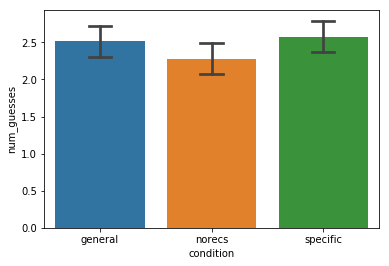

In [15]:
sns.barplot(x='condition', y='num_guesses', data=annotator_level_data, capsize=.2)

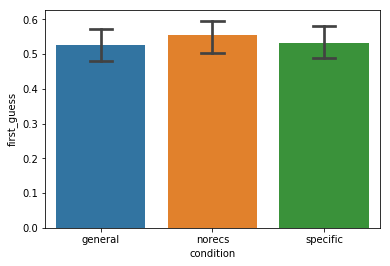

In [17]:
sns.barplot(x='condition', y='first_guess', data=annotator_level_data, capsize=.2)

In [84]:
joined_captions = {img['cocoid']: util.join_captions(img) for img in notebook_util.images}

To try:
supervisor, boss, director, doctor, 

In [89]:
HTML(show_images([idx for idx, caps in joined_captions.items() if '' in caps]))

In [86]:
notebook_util.id2img[391895]

{'filepath': 'val2014',
 'sentids': [770337, 771687, 772707, 776154, 781998],
 'filename': 'COCO_val2014_000000391895.jpg',
 'imgid': 0,
 'split': 'test',
 'sentences': [{'tokens': ['a',
    'man',
    'with',
    'a',
    'red',
    'helmet',
    'on',
    'a',
    'small',
    'moped',
    'on',
    'a',
    'dirt',
    'road'],
   'raw': 'A man with a red helmet on a small moped on a dirt road. ',
   'imgid': 0,
   'sentid': 770337},
  {'tokens': ['man',
    'riding',
    'a',
    'motor',
    'bike',
    'on',
    'a',
    'dirt',
    'road',
    'on',
    'the',
    'countryside'],
   'raw': 'Man riding a motor bike on a dirt road on the countryside.',
   'imgid': 0,
   'sentid': 771687},
  {'tokens': ['a',
    'man',
    'riding',
    'on',
    'the',
    'back',
    'of',
    'a',
    'motorcycle'],
   'raw': 'A man riding on the back of a motorcycle.',
   'imgid': 0,
   'sentid': 772707},
  {'tokens': ['a',
    'dirt',
    'path',
    'with',
    'a',
    'young',
    'person',

# Generate nAFC task

For each stimulus image, choose a foil set. It should be about equally difficult for each condition. Simplest approach: find the nearest caption to the concatenation of all captions we got for that image.

TODO: should we be computing similarities of individual captions, rather than complete images?

In [ ]:
cap_vectorizer, caption_vecs = util.get_vectorized_captions()

In [ ]:
caption_vecs.shape

In [ ]:
id2url[570528]

In [ ]:
concat_captions = {stimulus: '\n'.join(toolz.pluck('text', trials))
                   for stimulus, trials in toolz.groupby('stimulus', trial_data).items()}
concat_captions.keys()

In [ ]:
# print(concat_captions[71815])
# print(concat_captions[275449])
print(concat_captions[396295])

For 275449, the foil images are fixated on the 'wine'. But unsurprising, since all but one caption mentions it, and it's probably less common than "cat".

In [ ]:
def get_similar_images(caption, n=10):
    query_vec = cap_vectorizer.transform([caption])
    similarity = caption_vecs.dot(query_vec.T).A.ravel()
    return [images[idx]['cocoid'] for idx in np.argsort(similarity)[-n:][::-1]]
query_caption = concat_captions[396295].replace('wine', '') #trial_data[0]['text']
# query_caption = "a rusty and dirty shower in the bathroom has a tan towel over its handle"
# query_caption = "a sliding glass shower door with a bath mat hanging on it"
query_caption = "a closed shower door with crackled glass encases some hanging colored toiletries"
# print(query_caption)
# HTML(show_images(get_similar_images(query_caption)))

In [ ]:
def get_foil_set(*, stimulus, caption, rs):
    similar_images = get_similar_images(caption, n=10)
    if stimulus not in similar_images:
        print("Inserting", stimulus, 'into foil set')
        similar_images[-1] = stimulus
    rs.shuffle(similar_images)
    return similar_images
stimulus = trial_data[1]['stimulus']
get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=np.random.RandomState(1234))

In [ ]:
rs = np.random.RandomState(1234)
foil_sets = {
    stimulus: get_foil_set(stimulus=stimulus, caption=concat_captions[stimulus], rs=rs)
    for stimulus in sorted(concat_captions.keys())}

Group tasks so that (1) each annotator never gets the same target image twice and (2) each annotator never sees two captions from the same person. The latter criterion cannot always be met, though, since the number of annotators may not evenly divide the number of participants.

In [ ]:
import random
def shuffled(lst):
    lst = lst[:]
    random.shuffle(lst)
    return lst

In [ ]:
while True:
    trials_by_img = toolz.groupby('stimulus', shuffled(trial_data))
    annotators = []
    while not any(len(trials) == 0 for trials in trials_by_img.values()):
        trials_for_annotator = []
        participants_seen_by_annotator = set()
        for stimulus, trials in trials_by_img.items():
            for i in range(len(trials)):
                participant = trials[i]['participant']
                if participant not in participants_seen_by_annotator:
                    trials_for_annotator.append(trials.pop(i))
                    participants_seen_by_annotator.add(participant)
                    break
            else:
#                 print("Have to use the same participant again")
                trials_for_annotator.append(trials.pop(0))

        annotators.append(shuffled(trials_for_annotator))
    if all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators):
        break
    assert all(len(trials) == 0 for trials in trials_by_img.values())

In [ ]:
a = annotators[:]

In [ ]:
trials_by_img

Check that each annotator never gets the same target image twice

In [ ]:
assert all(len(set(toolz.pluck('stimulus', trials))) == len(trials) for trials in annotators)

Check that each annotator never sees two captions from the same person.

In [ ]:
assert all(len(set(toolz.pluck('participant', trials))) == len(trials) for trials in annotators)

In [ ]:
[len(trials) for trials in annotators]

In [ ]:
len(annotators)

In [ ]:
def make_task(stimulus, text):
    foil_set = foil_sets[stimulus]
    return dict(
        description=text,
        correct_idx=foil_set.index(stimulus),
        images=[id2url[idx] for idx in foil_set]
    )

In [ ]:
trial = annotators[0][0]
make_task(trial['stimulus'], trial['text'])

In [ ]:
guesses_task = pd.DataFrame([
    json.dumps([make_task(trial['stimulus'], trial['text']) for trial in annotator_trials])
    for annotator_trials in annotators], columns=['task'])
guesses_task.iloc[:1].to_csv(str(paths.data / 'anno-tasks' / 'guesses_test.csv'), index=False)
guesses_task.iloc[1:].to_csv(str(paths.data / 'anno-tasks' / 'guesses_remain.csv'), index=False)
guesses_task.to_csv(str(paths.data / 'anno-tasks' / 'guesses.csv'), index=False)

### Load MTurk results so far

In [ ]:
result_files = list((paths.data / 'mturk').glob('*-guesses.csv'))
batched_guesses_results = (
    pd.concat([pd.read_csv(str(f)) for f in result_files], axis=0, ignore_index=True)
)

In [ ]:
%matplotlib inline

In [ ]:
(batched_guesses_results['WorkTimeInSeconds']/60).hist(bins=30)

In [ ]:
def get_active_dur(results):
    pages = json.loads(results)
    try:
        first_guess = pages[0]['guesses'][0]['timestamp']
        last_guess = pages[-1]['guesses'][-1]['timestamp']
        return (last_guess - first_guess) / 1000 / 60
    except IndexError:
        # Something failed in the UI probably...
        return None
batched_guesses_results['Answer.results'].apply(get_active_dur).hist()
batched_guesses_results['Answer.results'].apply(get_active_dur).describe()
        

In [ ]:
batched_guesses_results[batched_guesses_results['Answer.results'].apply(lambda x: '"guesses":[]' in x)].T

In [ ]:
%debug

In [ ]:
guesses_results = []
for i, row in batched_guesses_results.iterrows():
    for page in json.loads(row['Answer.results']):
#         print(page)
        guess_indices = [guess['idx'] for guess in page['guesses']]
        if len(guess_indices) == 0:
            print("UI fail", row['WorkerId'])
            continue
#         guessed_right_sometime = [row.correctIdx in row.guess_indices for row in mturk_nafc_results.itertuples()]
        stimulus_url = [img for img in page['images'] if img['isCorrect']][0]['url']
        guesses_results.append(dict(
            guesser=row['WorkerId'],
            description=page['description'],
            num_guesses=len(guess_indices),
            stimulus_url=stimulus_url))
pd.DataFrame(guesses_results)

In [ ]:
num_responses_by_caption = mturk_nafc_results.groupby('Answer.description').size().to_dict()

### Generate tasks remaining

In [ ]:
# trials_todo = [trial for trial in trial_data if num_responses_by_caption.get(trial['text'], 0) < 3]
# len(trial_data), len(trials_todo)

In [ ]:
# i = 0
# while True:
#     out_fn = paths.data / 'anno-tasks' / f'{datetime.date.today().isoformat()}-{i}-nAFC.csv'
#     if not out_fn.exists():
#         break
#     i += 1
# out_fn

In [ ]:
# rs = np.random.RandomState(1234)
# pd.DataFrame([make_task(trial, rs) for trial in trials_todo]).to_csv(out_fn, index=False)

### Generate the actual HIT text...

In [ ]:
from jinja2 import Template
html = Template(open(paths.top_level / 'HITs' / '2018-05-04-image-description-match.jinja.html').read()).render(dict(
    description='${description}',
    images=['${image_%d_url}' % i for i in range(10)]))

In [ ]:
html2 = html
trial = trial_data[18+7*9]
for k, v in make_task(trial['stimulus'], trial['text']).items():
    html2 = html2.replace('${' + k + '}', str(v))
HTML('<div style="height: 1000px; position: relative;">'+html2+'</div>')
# print(html2)

In [ ]:
import subprocess
subprocess.Popen('pbcopy', stdin=subprocess.PIPE).communicate(html.encode('utf-8'))

# Analyze MTurk results

In [ ]:
mturk_nafc_results.groupby('Answer.description').num_guesses.mean().to_dict()

In [ ]:
%matplotlib inline

In [ ]:
(mturk_nafc_results['WorkTimeInSeconds'][mturk_nafc_results['WorkTimeInSeconds'] < 5*60] / 60).hist(bins=30)

In [ ]:
np.median(mturk_nafc_results['WorkTimeInSeconds'] / 60) * 9/60

In [ ]:
(
    15 # participants
    * 3 # conditions per participant
    * 3 # captions per condition
    - 1 # image not shown
) * 3 # annotators per description


In [ ]:
    * .24 # reward per annotator
) * 1.2 # MTurk 20% fee

Did the same worker see the same target image multiple times?

In [ ]:
next(data.iterrows())[1]['Input.image_0_url']

In [ ]:
mturk_nafc_results['target_image_url'] = [row['Input.image_'+str(row['correctIdx'])+"_url"] for _, row in mturk_nafc_results.iterrows()]

In [ ]:
bad_worker_image_pairs = set()
for worker_id, data in mturk_nafc_results.groupby('WorkerId'):
    target_images = [row['target_image_url'] for _, row in data.iterrows()]
    if len(target_images) != len(set(target_images)):
#         print(worker_id)
        value_counts = pd.Series(target_images).value_counts()
        value_counts = value_counts[value_counts > 1]
#         print(value_counts)
        for img in value_counts.index:
            bad_worker_image_pairs.add((worker_id, img))
bad_worker_image_pairs

annotation_row_is_bad = [
    (row['WorkerId'], row['target_image_url']) in bad_worker_image_pairs
    for _, row in mturk_nafc_results.iterrows()
]
mturk_nafc_results['row_is_bad'] = annotation_row_is_bad

In [ ]:
mturk_nafc_results['row_is_bad'].mean()

In [ ]:
guess_results = mturk_nafc_results[~mturk_nafc_results['row_is_bad']].rename(columns={'Answer.description': 'text'})

In [ ]:
len(mturk_nafc_results)

In [ ]:
len(guess_results), len(trial_data)

In [ ]:
trial_data

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    guess_results.rename(columns={'WorkerId': 'guesser'}).drop(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'RequesterAnnotation', 'guesses'], axis=1),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
guesses_results[0]

In [ ]:
annotator_level_data = pd.merge(
    pd.DataFrame(trial_data).rename(columns={'participant': 'writer'}),
    pd.DataFrame(guesses_results).rename(columns={'description': 'text'}),
    on='text', validate='1:m', how='right')
annotator_level_data
    #.groupby().num_guesses.mean().to_frame('mean_num_guesses'),
#     left_on='text', right_index=True).groupby('condition').mean_num_guesses.aggregate(['mean', 'std'])

In [ ]:
annotator_level_data.columns

In [ ]:
annotator_level_data.to_csv('annotator_level_data_2018-05-22v2.csv', index=False)

In [ ]:
(annotator_level_data['num_guesses'] == 1).mean()

In [ ]:
%pwd

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
library(lme4)
library(ggplot2)

In [ ]:
%%R -i annotator_level_data
(model = lmer(num_guesses ~ condition + (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(null_model = lmer(num_guesses ~ (1|writer) + (1|guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
library(pbkrtest)

In [ ]:
%%R
(kr <- KRmodcomp(model, null_model))

In [ ]:
%%R -i annotator_level_data
(glm.full = glmer(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
(glm.null = glmer(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data, family=poisson()))

In [ ]:
%%R
#confint(glm.full)

In [ ]:
%%R
anova(glm.full, glm.null, test="Chisq")

In [ ]:
%%R -i annotator_level_data
(nb_model = glmer.nb(num_guesses ~ condition + (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R -i annotator_level_data
(nb_model.null = glmer.nb(num_guesses ~ (1|writer) + (1+guesser) + (1|stimulus), annotator_level_data))

In [ ]:
%%R
anova(nb_model, nb_model.null, test="Chisq")

In [ ]:
results = pd.DataFrame([dict(trial, specificity=specificity_lookup[trial['text'].strip()]) for trial in trial_data])
for col in ['condition', 'participant']:
    results[col] = results[col].astype('category')
results.info()

In [ ]:
results.groupby('condition').specificity.mean()

In [ ]:
pd.DataFrame(trial_data).sample(frac=1.0).sort_values('stimulus').to_csv('trial_data_by_stimulus.csv')